In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm

from vax_sims_LHS_samples import *
from plot_utils import *
# from util_functions import *
# from uncertainty_analysis import *
# from sim_helper_functions import *

# Code to load and process simulation data 

In [18]:
base_folders = ['posterior_test_frequency_sims_1633644447/',
               'posterior_test_frequency_sims_1633644474/',
               'posterior_test_frequency_sims_1633644517/',
               'posterior_test_frequency_sims_1633644560/']

def get_fname_params(fname):
    fname_without_ext = fname.split('.')[0]
    fname_list = fname_without_ext.split('_')
    posterior_point_idx = int(fname_list[2])
    test_policy_num = int(fname_list[5])
    vax_rate_idx = int(fname_list[8])
    return posterior_point_idx, test_policy_num, vax_rate_idx

sim_trajs = {}
sim_uncertainty_points = {}


count = 0

for base_folder in base_folders:
    if base_folder == 'posterior_test_frequency_sims_1633644474/':
        override_vax_idx = 4
    else:
        override_vax_idx = None
    print("On folder {} we are using {} to override the vax_idx".format(base_folder, override_vax_idx))
    for fname in os.listdir(base_folder):
        with open(os.path.join(base_folder, fname), "rb") as fhandle:
            point_idx, policy_num, vax_idx = get_fname_params(fname)
            if override_vax_idx != None:
                vax_idx = override_vax_idx
            posterior_point, inf_trajs_by_group = dill.load(fhandle)
            sim_trajs[point_idx, policy_num, vax_idx] = inf_trajs_by_group
            sim_uncertainty_points[point_idx, policy_num, vax_idx] = posterior_point
            count += 1
            if count % 50 == 0:
                print("loaded {} sim outputs".format(count))


On folder posterior_test_frequency_sims_1633644447/ we are using None to override the vax_idx
loaded 50 sim outputs
loaded 100 sim outputs
loaded 150 sim outputs
loaded 200 sim outputs
loaded 250 sim outputs
loaded 300 sim outputs
loaded 350 sim outputs
loaded 400 sim outputs
loaded 450 sim outputs
loaded 500 sim outputs
loaded 550 sim outputs
loaded 600 sim outputs
loaded 650 sim outputs
loaded 700 sim outputs
loaded 750 sim outputs
loaded 800 sim outputs
loaded 850 sim outputs
loaded 900 sim outputs
loaded 950 sim outputs
loaded 1000 sim outputs
loaded 1050 sim outputs
loaded 1100 sim outputs
loaded 1150 sim outputs
loaded 1200 sim outputs
loaded 1250 sim outputs
loaded 1300 sim outputs
loaded 1350 sim outputs
loaded 1400 sim outputs
loaded 1450 sim outputs
loaded 1500 sim outputs
loaded 1550 sim outputs
loaded 1600 sim outputs
loaded 1650 sim outputs
On folder posterior_test_frequency_sims_1633644474/ we are using 4 to override the vax_idx
loaded 1700 sim outputs
loaded 1750 sim out

In [19]:
UNCERTAINTY_PARAMS = ['vax_susc_mult', 
                      'vax_transmission_mult', 
                      'contacts_per_day_mult', 
                      'outside_infection_rate_mult',
                      'cases_isolated_per_contact_trace', 
                      'initial_ID_prevalence']

from launch_fall_2021_posterior_sims_whale import load_posterior_df

def process_sim_output(sim_trajs, sim_uncertainty_points):
    posterior_df = load_posterior_df()
    posterior_df['normalized_posterior'] = posterior_df['posterior'] / posterior_df['posterior'].sum()
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+\
                                 ['posterior_idx', 'vax_rate_idx', 'test_policy_num'] + \
                                 ['normalized_posterior'] + \
                                 ['student_inf_10','student_inf_50','student_inf_90'] 
                                )
    for point_idx, policy_num, vax_idx in sim_trajs:
        
        inf_matrix = np.array(sim_trajs[point_idx, policy_num, vax_idx])
        student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
        uncertainty_point = sim_uncertainty_points[point_idx, policy_num, vax_idx]

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['posterior_idx'] = point_idx
        new_row['vax_rate_idx'] = vax_idx
        new_row['test_policy_num'] = policy_num
        new_row['normalized_posterior'] = posterior_df['normalized_posterior'].iloc[point_idx]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

scenario_data = process_sim_output(sim_trajs, sim_uncertainty_points)

# sanity check to make sure every point_idx corresponds to a unique point

In [20]:
for posterior_idx in set(scenario_data['posterior_idx']):
    subdf = scenario_data[scenario_data['posterior_idx'] == posterior_idx]
    for param_name in UNCERTAINTY_PARAMS:
        assert(len(set(subdf[param_name])) == 1)

In [24]:
def posterior_weighted_stats(subdf):
    weighted_median_infs = []
    for idx in range(subdf.shape[0]):
        median_infs = subdf['student_inf_50'].iloc[idx]
        weight = subdf['normalized_posterior'].iloc[idx]
        weighted_median_infs.append((median_infs, weight))

    sorted_weighted_median_infs = sorted(weighted_median_infs, key=lambda x: x[0])
    p25_idx = -1 # want cumulative_posterior(p25_idx) < 0.25 and cumulative_posterior(p25_idx+1) >= 0.25
    p50_idx = -1 # same as above but with 0.5
    p75_idx = -1 # cum_posterior(p75_dx - 1) < 0.75 and cum_posterior(p75_idx) >= 0.75

    cum_weight = 0
    for idx in range(len(sorted_weighted_median_infs)):
        median_infs, weight = sorted_weighted_median_infs[idx]

        prev_cum_weight = cum_weight
        cum_weight += weight

        if cum_weight >= 0.25 and prev_cum_weight < 0.25:
            p25_idx = idx - 1

        if cum_weight >= 0.5 and prev_cum_weight < 0.5:
            p50_idx = idx - 1

        if cum_weight >= 0.75 and prev_cum_weight < 0.75:
            p75_idx = idx 

    p25_val = sorted_weighted_median_infs[p25_idx][0]
    p50_val = sorted_weighted_median_infs[p50_idx][0]
    p75_val = sorted_weighted_median_infs[p75_idx][0]

    return p25_val, p50_val, p75_val

# Plotting code

In [25]:
policy_nums = sorted(list(set(scenario_data['test_policy_num'])))
assert(len(policy_nums) == 8)

vax_rate_idxs = sorted(list(set(scenario_data['vax_rate_idx']) ))
assert(len(vax_rate_idxs) == 5)

print(policy_nums)
print(vax_rate_idxs)

median_inf_25 = {policy_num: [] for policy_num in policy_nums}
median_inf_50 = {policy_num: [] for policy_num in policy_nums}
median_inf_75 = {policy_num: [] for policy_num in policy_nums}

for policy_num in policy_nums:
    for vax_rate_idx in vax_rate_idxs:
        subdf = scenario_data[(scenario_data['test_policy_num'] == policy_num) & \
                             (scenario_data['vax_rate_idx'] == vax_rate_idx)]
        assert(subdf.shape[0] == 106)
        p25, p50, p75 = posterior_weighted_stats(subdf)
        
        median_inf_25[policy_num].append(p25)
        median_inf_50[policy_num].append(p50)
        median_inf_75[policy_num].append(p75)


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[0.0, 1.0, 2.0, 3.0, 4.0]


In [28]:
vax_rates_x[0:3]

[25, 50, 75]

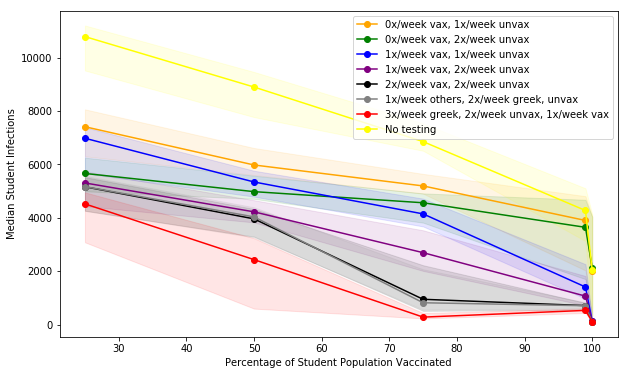

In [26]:
from test_policies import policy_labels
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
vax_rates_x = [25, 50, 75, 99, 100]


colours = ['orange', 'green', 'blue', 'purple', 'black', 'gray', 'red', 'yellow']

for policy_num, colour in zip(policy_nums, colours):
    plt.plot(vax_rates_x, median_inf_50[policy_num], color=colour, 
             marker='o', label=policy_labels[int(policy_num)])
    plt.fill_between(vax_rates_x, 
                     y1=median_inf_25[policy_num], 
                     y2=median_inf_75[policy_num],
                     color=colour, alpha=0.1)
    
plt.xlabel("Percentage of Student Population Vaccinated")
plt.ylabel("Median Student Infections")
plt.legend()
plt.show()

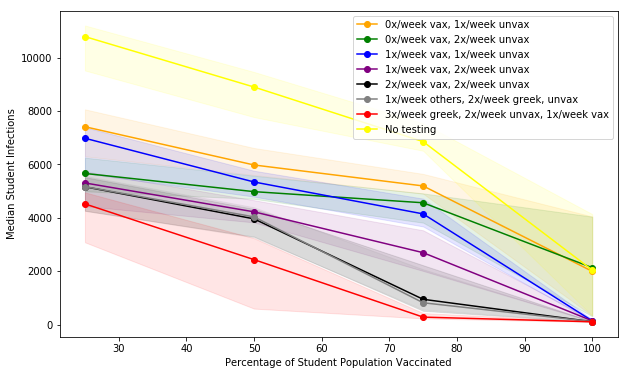

In [29]:
from test_policies import policy_labels
import matplotlib.pyplot as plt
%matplotlib inline

def drop_vax_99(l):
    return l[0:3] + [l[4]]

plt.figure(figsize=(10,6))
vax_rates_x = [25, 50, 75, 99, 100]


colours = ['orange', 'green', 'blue', 'purple', 'black', 'gray', 'red', 'yellow']

for policy_num, colour in zip(policy_nums, colours):
    plt.plot(drop_vax_99(vax_rates_x), drop_vax_99(median_inf_50[policy_num]), color=colour, 
             marker='o', label=policy_labels[int(policy_num)])
    plt.fill_between(drop_vax_99(vax_rates_x), 
                     y1=drop_vax_99(median_inf_25[policy_num]), 
                     y2=drop_vax_99(median_inf_75[policy_num]),
                     color=colour, alpha=0.1)
    
plt.xlabel("Percentage of Student Population Vaccinated")
plt.ylabel("Median Student Infections")
plt.legend()
plt.show()